In [1]:
import os, os.path
import glob
import pickle
import numpy
from numpy.polynomial import Polynomial
from scipy import ndimage, signal, interpolate
#import matplotlib
#matplotlib.use('PDF')
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.util import bovy_conversion, save_pickles, bovy_coords, bovy_plot
import pal5_util
from gd1_util import R0, V0
import custom_stripping_df
import seaborn as sns
import astropy.units as u
from galpy import potential
%pylab inline
from matplotlib import cm, pyplot
from __future__ import print_function




/home/nil/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters

Populating the interactive namespace from numpy and matplotlib


In [2]:
#define functions

def galcencyl_to_lbd(R,phi,Z,degree=True):
        xyz=bovy_coords.galcencyl_to_XYZ(R,phi,Z)
        l=[]
        b=[]
        d=[]
        for ii in range(len(xyz)):
            lbd=bovy_coords.XYZ_to_lbd(xyz[ii][0],xyz[ii][1],xyz[ii][2],degree=degree)
            l.append(lbd[0])
            b.append(lbd[1])
            d.append(lbd[2])
            
        return (l,b,d)
                     


In [3]:
def process_sample(dir_trail,out_format='radec'):
    #dir_trail contains all the sample files from the trailing arm
    #convert R,z,phi to ra,dec to xi, eta
    dir_lead = dir_trail.replace('trailing','leading')
    allfname_trail= glob.glob(dir_trail + '*.dat')
    allfname_lead= glob.glob(dir_lead + '*.dat')
    R_t=[]
    phi_t=[]
    z_t=[]

    R_l=[]
    phi_l=[]
    z_l=[]

    for i in range(len(allfname_trail)):
        R_t.append(numpy.loadtxt(allfname_trail[i])[:,0])
        phi_t.append(numpy.loadtxt(allfname_trail[i])[:,1])
        z_t.append(numpy.loadtxt(allfname_trail[i])[:,2])
        
    for ii in range(len(allfname_lead)):
        R_l.append(numpy.loadtxt(allfname_lead[ii])[:,0])
        phi_l.append(numpy.loadtxt(allfname_lead[ii])[:,1])
        z_l.append(numpy.loadtxt(allfname_lead[ii])[:,2])
        
    Rall_t = np.array([item for sublist in R_t for item in sublist])
    phiall_t = np.array([item for sublist in phi_t for item in sublist])
    zall_t = np.array([item for sublist in z_t for item in sublist])

    Rall_l = np.array([item for sublist in R_l for item in sublist])
    phiall_l = np.array([item for sublist in phi_l for item in sublist])
    zall_l = np.array([item for sublist in z_l for item in sublist])
    
    l_t,b_t,d_t=np.array(galcencyl_to_lbd(Rall_t,phiall_t,zall_t))
    l_l,b_l,d_l=np.array(galcencyl_to_lbd(Rall_l,phiall_l,zall_l))
    
    radec_t=bovy_coords.lb_to_radec(l_t,b_t,degree=True) 
    radec_l=bovy_coords.lb_to_radec(l_l,b_l,degree=True) 
    
    if out_format=='radec' :
        return (radec_t[:,0],radec_t[:,1],radec_l[:,0],radec_l[:,1])
    
    elif out_format=='xieta':
        
        mxieta_t= pal5_util.radec_to_pal5xieta(radec_t[:,0],radec_t[:,1],degree=True)
        xi_t= mxieta_t[:,0]
        eta_t=mxieta_t[:,1]

        mxieta_l= pal5_util.radec_to_pal5xieta(radec_l[:,0],radec_l[:,1],degree=True)
        xi_l= mxieta_l[:,0]
        eta_l=mxieta_l[:,1]
    
        return (xi_t,eta_t,xi_l,eta_l)
        
    else : 
        print ("acceptable output format : radec or xieta")
        

def compute_ndenxi(xi,minxi=0.25,maxxi=14.35,bw=0.1,polydeg=3,plot=True,fname=''):
    N=len(xi)
    print (N)
    minxi = minxi
    maxxi= maxxi
    bw= bw

    nbins= (maxxi - minxi)/bw
    print ("no of xi bins = %i"%nbins)

    xibin_edge=[(minxi-0.5*bw) + i*bw for i in range(int(nbins)+2)]
    #print (xibin_edge)
    midxi=[0.5*(xibin_edge[i] + xibin_edge[i+1]) for i in range(int(nbins)+1)]
    
    nden=np.histogram(xi,xibin_edge,density=True)[0]
    Ndn=np.histogram(xi,xibin_edge)[0]
    print (np.sum(Ndn))
    shot_noise=numpy.sqrt(Ndn)
    err=shot_noise/(N*bw)
    
    pp= Polynomial.fit(midxi,Ndn,deg=polydeg,w=1/err)
    nden=Ndn/pp(np.array(midxi))
        
    if plot :
            plt.figure(figsize=(20,10))
            plt.subplot(1,2,1)
            plt.plot(midxi,Ndn,ls='steps-mid')
            plt.errorbar(midxi,Ndn,err,marker='None',ls='None')
            plt.plot(midxi,pp(np.array(midxi)),c='r',label=r'$3^{\rm{rd}}$ order polynomial')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('Star count',fontsize=18)
            plt.legend(loc='upper right',fontsize=18)
    
            plt.subplot(1,2,2)
            plt.plot(midxi,nden,ls='steps-mid')
            plt.errorbar(midxi,nden,err,marker='None',ls='None')
            plt.xlabel(r'$\xi$ (deg)',fontsize=18)
            plt.ylabel('normalized star count',fontsize=18)
            
            if fname != '' :
                plt.savefig(fname)
            
            plt.show()
            
    return (midxi,nden,err)
  

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 40$ 2 Gyr bar grown over 2 bar period

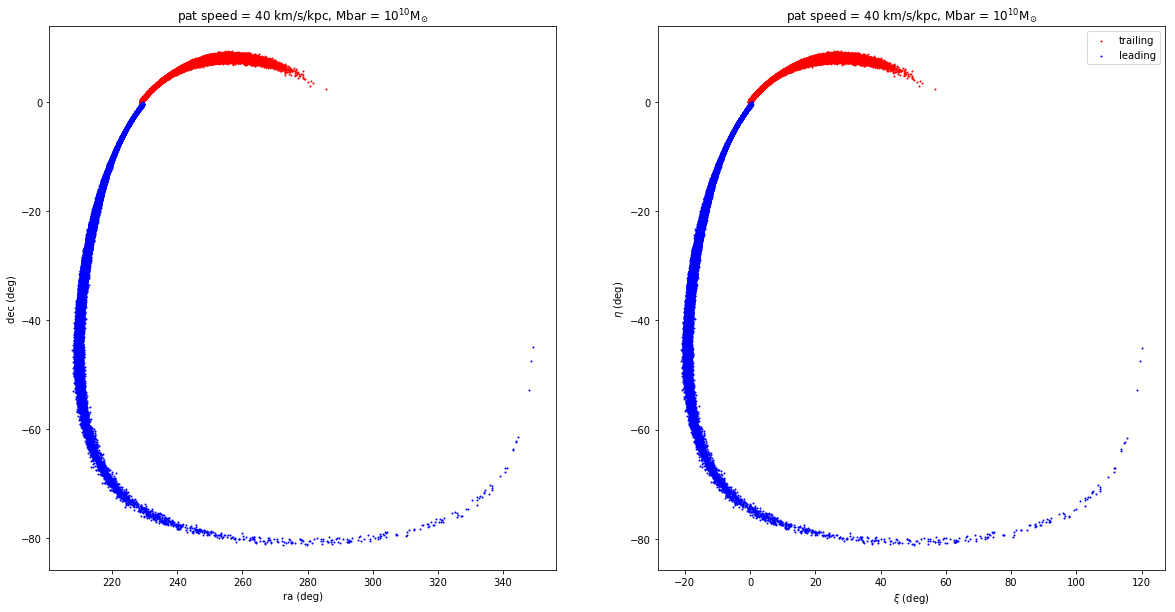

In [7]:
dir40_bargrow='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_2Gyr_bargrow/trailing/'
ra_t, dec_t,ra_l,dec_l=process_sample(dir40_bargrow,out_format='radec')
xi_t,eta_t,xi_l,eta_l=process_sample(dir40_bargrow,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t,dec_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l,dec_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')

plt.savefig('plots/1010Msun_2Gyrbargrow_2barperiod_sky_coords.pdf',format='pdf',dpi=100)
plt.show()



501000
no of xi bins = 141
328888


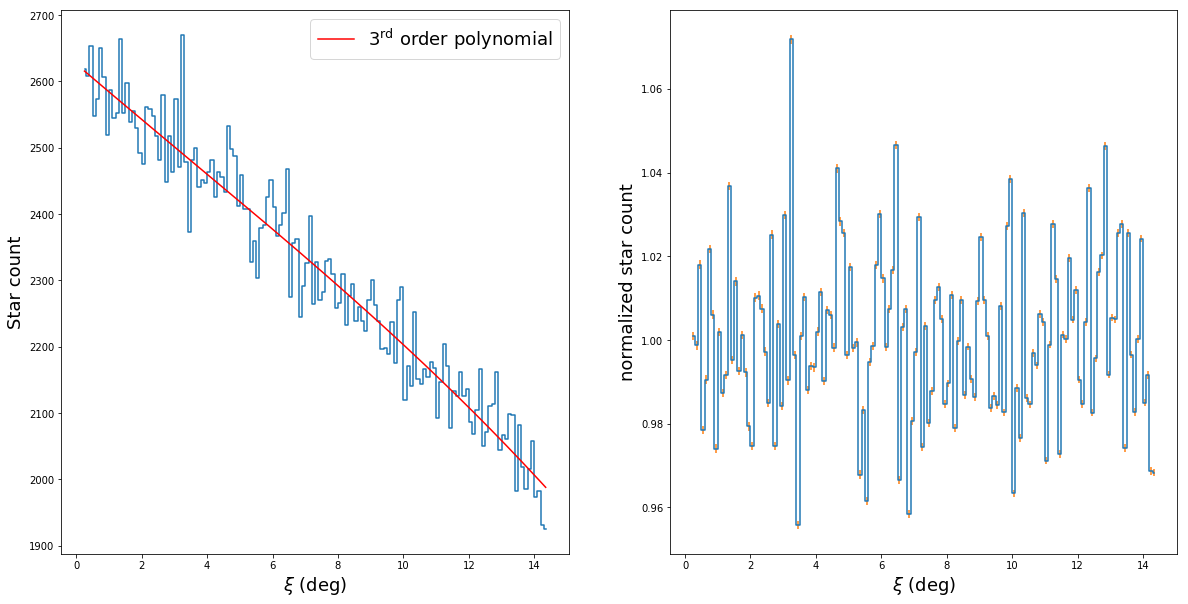

In [8]:
#compute density along xi and save 

midxi,nden,err = compute_ndenxi(xi_t,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10_bargrow2_barspeed40_phi27_polydeg3.pdf')

In [9]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_2Gyr_bargrow/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_2Gyr_bargrow2barperiod_barphi27_patspeed40.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

In [12]:
def compute_Pk(filename, scaling = 'spectrum'):
    data= numpy.loadtxt(filename)
    p1=data[:,0]
    tdata=data[:,1]
    data_err=data[:,2]
    
    px,py= signal.csd(tdata,tdata,fs=1./(p1[1]-p1[0]),scaling=scaling,nperseg=len(p1))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(p1[-1]-p1[0]))
    
            
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(p1))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(p1[1]-p1[0]),scaling=scaling,
                                nperseg=len(p1))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(p1[-1]-p1[0]))
    
    #return 180./px/numpy.pi, py, py_err #if apars
    return px, py, py_err




def set_ranges_and_labels_dens():
    bovy_plot.bovy_text(r'$\sqrt{\delta\delta}$',top_left=True,size=18.)
    xlabel(r'$1/k_{\xi}\,(\mathrm{deg})$',size=18)
    ylim(0.0001,10.)
    xlim(1,150.)
    for axis in [gca().xaxis,gca().yaxis]:
        axis.set_major_formatter(FuncFormatter(
                lambda y,pos: (r'${{:.{:1d}f}}$'.format(int(numpy.maximum(-numpy.log10(y),0)))).format(y)))
    return None

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':



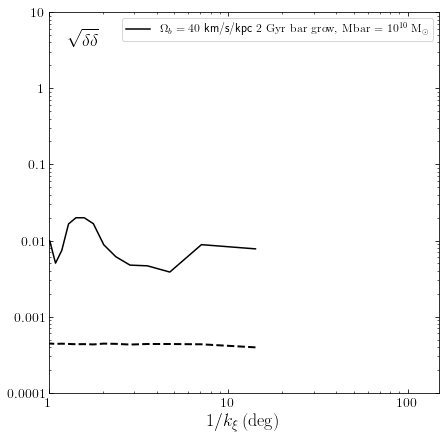

In [16]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename=outdir + '1010Msun_patspeed40_2Gyr_bargrow/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_2Gyr_bargrow2barperiod_barphi27_patspeed40.dat'
px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px,py,color='k',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')





# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 40$ 5 Gyr bar grown over 2 bar period

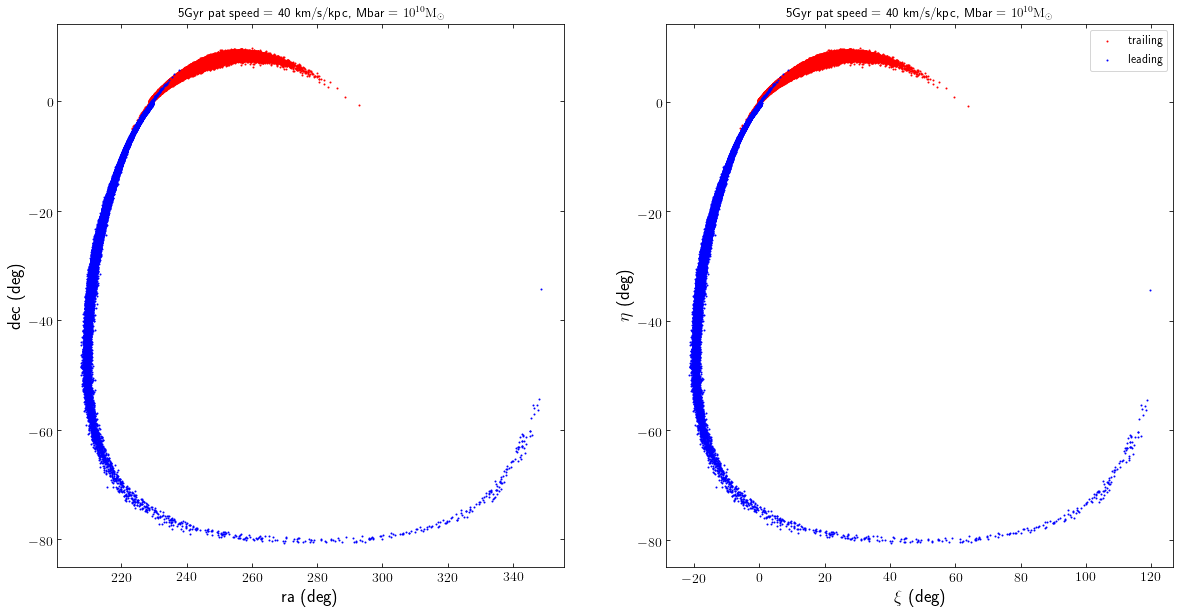

In [24]:
dir40_bargrow_1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_bargrow/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir40_bargrow_1,out_format='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir40_bargrow_1,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'5Gyr pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'5Gyr pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')

plt.savefig('plots/1010Msun_5Gyrbargrow_2barperiod_sky_coords.pdf',format='pdf',dpi=100)
plt.show()



120000
no of xi bins = 141
84236


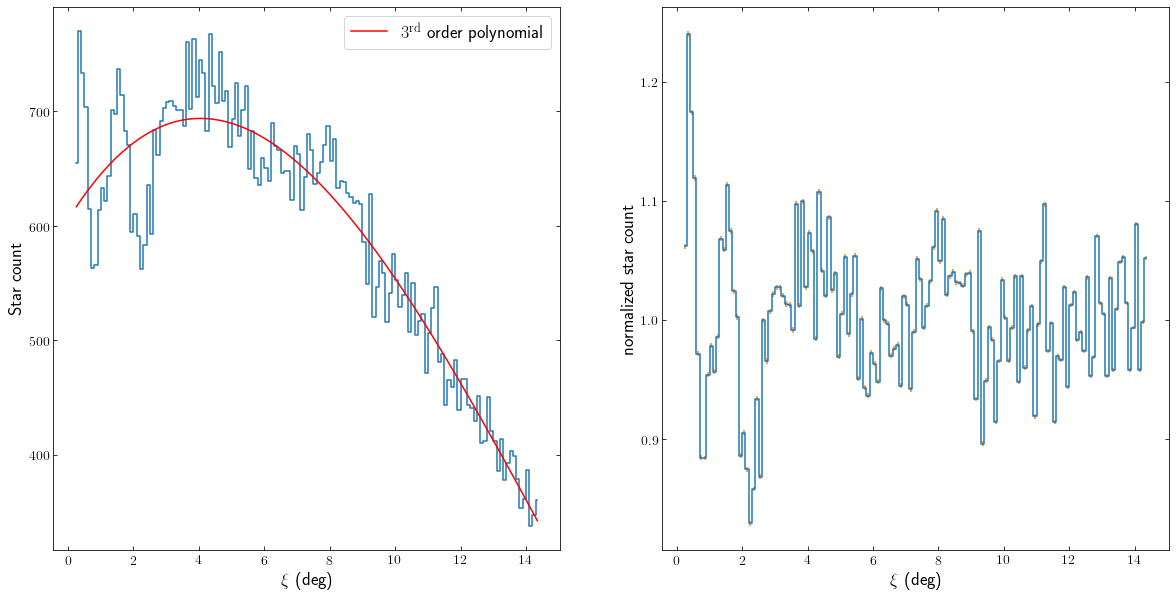

In [25]:
#compute density along xi and save 

midxi1,nden1,err1 = compute_ndenxi(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10_bargrow5_barspeed40_phi27_polydeg3.pdf')

In [26]:
#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_bargrow/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden1)):
    fo.write(str(midxi1[j]) + "   " + str(nden1[j]) + "   " + str(err1[j]) + "\n")
    
fo.close()

# include stars from both arms

120000 35448


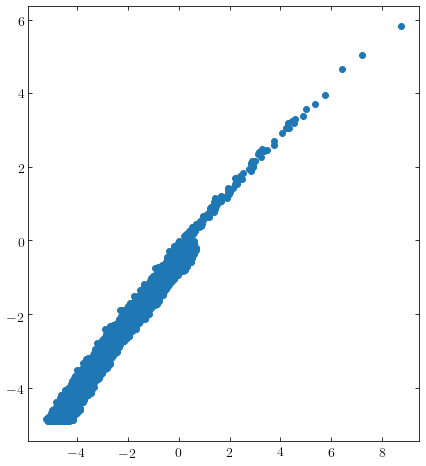

155448
no of xi bins = 141
85186


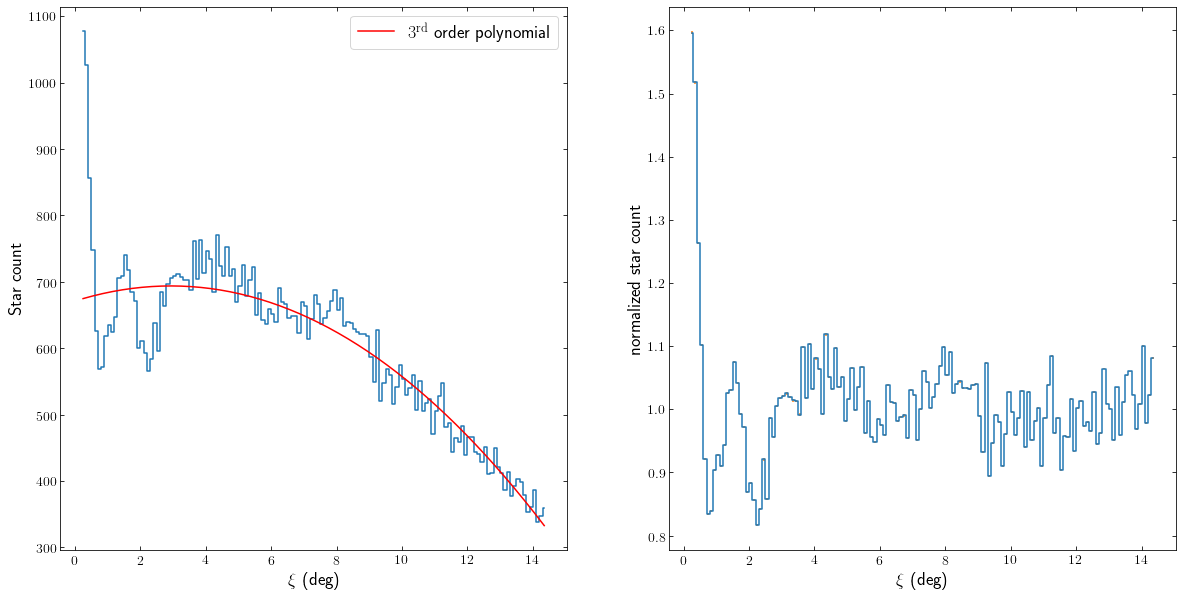

In [27]:
def include_both_arms(xi_t,eta_t,xi_l,eta_l):
    min_eta_t=min(eta_t)
    max_eta_t=max(eta_t)

    xi_l_select=[]
    eta_l_select=[]

    for jj in range(len(eta_l)):
        if min_eta_t <= eta_l[jj] <= max_eta_t :
            xi_l_select.append(xi_l[jj])
            eta_l_select.append(eta_l[jj])

    print (len(xi_l), len(xi_l_select))

    plt.figure()
    plt.scatter(xi_l_select,eta_l_select)
    plt.show()
    
    xi_all = np.concatenate((xi_t,xi_l_select))
    
    return xi_all

xi_both_arms1=include_both_arms(xi_t1,eta_t1,xi_l1,eta_l1)
midxi_all1,nden_all1,err_all1 = compute_ndenxi(xi_both_arms1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.pdf')

outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40_5Gyr_bargrow/'
fo_all1=open(outdir1 + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all1)):
    fo_all1.write(str(midxi_all1[jj]) + "   " + str(nden_all1[jj]) + "   " + str(err_all1[jj]) + "\n")
    
fo_all1.close()

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':



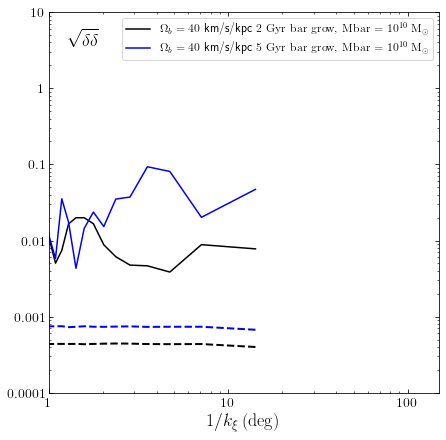

In [28]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename=outdir + '1010Msun_patspeed40_2Gyr_bargrow/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_2Gyr_bargrow2barperiod_barphi27_patspeed40.dat'
px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')

filename1=outdir + '1010Msun_patspeed40_5Gyr_bargrow/Pal5_density_samples_polyfit3_both_arms_SCFbarMbar1010_5Gyr_bargrow2barperiod_barphi27_patspeed40.dat'
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px,py,color='k',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='k',zorder=1,ls='--')

loglog(px1,py1,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{5 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='b',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')





# Plot Pal 5 power spectrum and compare with the power due to the bar

In [21]:
#load the saved pickle file for converting apars to obs coords
with open('/home/nil/Dropbox/streamgap-pepper/pal5_64sampling.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')



# Convert track to xi, eta
trackRADec=\
  bovy_coords.lb_to_radec(sdf_smooth._interpolatedObsTrackLB[:,0],
                          sdf_smooth._interpolatedObsTrackLB[:,1],
                          degree=True)
trackXiEta=\
  pal5_util.radec_to_pal5xieta(trackRADec[:,0],
                    trackRADec[:,1],degree=True)
smooth_track= []
for coord in range(6):
    if coord < 2:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     trackXiEta[:,coord]))
    else:
        smooth_track.append(\
            interpolate.InterpolatedUnivariateSpline(sdf_smooth._interpolatedThetasTrack,
                                                     sdf_smooth._interpolatedObsTrackLB[:,coord]))
smooth_ll= interpolate.InterpolatedUnivariateSpline(trackXiEta[:,0],
                                                    sdf_smooth._interpolatedThetasTrack)
def convert_dens_to_obs(apars,dens,dens_smooth,mO,poly_deg=3):
    """
    NAME:
        convert_dens_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        dens - density(apars)
        dens_smooth - smooth-stream density(apars)
        mO= (None) mean parallel frequency (1D) 
            [needs to be set to get density on same grid as track]
        poly_deg= (3) degree of the polynomial to fit for the 'smooth' stream
    OUTPUT:
        (xi,dens/smooth)
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    outll= numpy.arange(minxi,14.35,0.1)
    # Interpolate density
    ipll= interpolate.InterpolatedUnivariateSpline(mxieta[:,0],apars)
    ipdens= interpolate.InterpolatedUnivariateSpline(apars,dens/dens_smooth)
    return (outll,ipdens(ipll(outll)))
def convert_track_to_obs(apars,mO,coord):
    """
    NAME:
        convert_track_to_obs
    PURPOSE:
        Convert track to observed coordinates
    INPUT:
        apars - parallel angles
        mO - mean parallel frequency (1D)
        coord - coordinate to convert to (1: eta, 2: distance, 3: vlos, 4: pmll, 5: pmbb)
    OUTPUT:
        (longitude,(track-smooth)[coord])
    """
    mT= sdf_pepper.meanTrack(apars,_mO=mO,coord='lb')
    mradec= bovy_coords.lb_to_radec(mT[0],mT[1],degree=True)
    mxieta= pal5_util.radec_to_pal5xieta(mradec[:,0],mradec[:,1],degree=True)
    mT[0]= mxieta[:,0]
    mT[1]= mxieta[:,1]
    # Interpolate
    ipll= interpolate.InterpolatedUnivariateSpline(mT[0],apars)
    ipcoord= interpolate.InterpolatedUnivariateSpline(apars,mT[coord])
    outll= numpy.arange(minxi,14.35,0.1)
    return (outll,ipcoord(ipll(outll))-smooth_track[coord](smooth_ll(outll)))    
def read_data(filename):
    data1= numpy.genfromtxt(filename,delimiter=',',max_rows=5002)
    # Search for batches
    batchfilenames= glob.glob(filename.replace('.dat','.*.dat'))
    for bfilename in batchfilenames:
        try:
            datab= numpy.genfromtxt(bfilename,delimiter=',')
        except: continue
        data1= numpy.vstack((data1,datab[2:]))
    return data1
def read_dens(filename,indx=None,rand=False,poly_deg=3):
    densdata= read_data(filename)
    mOfilename= filename.replace('dens','omega')
    mOdata= read_data(mOfilename)
    apars= densdata[0]
    nsim= len(densdata)-2 # first two are apar and smooth
    ll,tdata1= convert_dens_to_obs(apars,densdata[2],densdata[1],
                                   mOdata[2],poly_deg=poly_deg)
    if not indx is None:
        return convert_dens_to_obs(apars,densdata[2+indx],densdata[1],
                                   mOdata[2+indx])
    if rand:
        rindx= int(numpy.floor(numpy.random.uniform()*nsim))
        print (rindx)
        return convert_dens_to_obs(apars,densdata[2+rindx],densdata[1],
                                   mOdata[2+rindx])
    out= numpy.zeros((nsim,len(tdata1)))
    for ii in range(nsim):
        ll, tdata1= convert_dens_to_obs(apars,densdata[2+ii],densdata[1],
                                        mOdata[2+ii])
        out[ii]= tdata1
    return (ll,out)
def median_csd(filename,filename2=None,scatter=False,
              coord1=1,coord2=1,
              err1=None,err2=None,
              poly_deg=3):
    # Compute the median CSD, if filename2 is not None, compute cross
    data1= read_data(filename)
    if filename2 is None:
        data2= data1
    else:
        data2= read_data(filename2)
    if coord1 == 'dens':
        mOfilename= filename.replace('dens','omega')
        mOdata1= read_data(mOfilename)
    if coord2 == 'dens':
        if filename2 is None:
            mOdata2= mOdata1
        else:
            mOfilename2= filename2.replace('dens','omega')
            mOdata2= read_data(mOfilename2)
    apars= data1[0]
    nsim= len(data1)-2 # first two are apar and smooth
    if nsim < 1000:
        print ("WARNING: Using fewer than 1,000 (%i) simulations to compute medians from %s" % (nsim,filename))
    if coord1 == 'dens':
        ll,tdata1= convert_dens_to_obs(apars,data1[2],data1[1],mOdata1[2],poly_deg=poly_deg)
    else:
        ll,tdata1= convert_track_to_obs(apars,data1[2],coord1)
    if coord2 == 'dens':
        ll,tdata2= convert_dens_to_obs(apars,data2[2],data2[1],mOdata2[2],poly_deg=poly_deg)
    else:
        ll,tdata2= convert_track_to_obs(apars,data2[2],coord2)
    px= signal.csd(tdata1,tdata2,fs=1./(ll[1]-ll[0]),scaling=scaling,nperseg=len(ll))[0]
    ppy= numpy.empty((nsim,len(px)))
    ppy_err= numpy.empty((nsim,len(px)))
    for ii in range(nsim):
        # convert
        if coord1 == 'dens':
            ll,tdata1= convert_dens_to_obs(apars,data1[2+ii],data1[1],mOdata1[2+ii],poly_deg=poly_deg)
        else:
            ll,tdata1= convert_track_to_obs(apars,data1[2+ii],coord1)
        if numpy.any(data1[2+ii] != data2[2+ii]):
            if coord2 == 'dens':
                ll,tdata2= convert_dens_to_obs(apars,data2[2+ii],data2[1],mOdata2[2+ii],poly_deg=poly_deg)
            else:
                ll,tdata2= convert_track_to_obs(apars,data2[2+ii],coord2)
            ppy[ii]= numpy.absolute(signal.csd(tdata1,tdata2,
                                               fs=1./(ll[1]-ll[0]),scaling=scaling,
                                               nperseg=len(ll))[1])
        else:
            ppy[ii]= signal.csd(tdata1,tdata1,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
        # Same for errors
        if not err1 is None:
            tmock1= err1*numpy.random.normal(size=len(ll))
            if numpy.any(data1[2+ii] != data2[2+ii]):
                tmock2= err2*numpy.random.normal(size=len(ll))
                ppy_err[ii]= numpy.absolute(signal.csd(tmock1,tmock2,
                                                       fs=1./(ll[1]-ll[0]),scaling=scaling,
                                                       nperseg=len(ll))[1])
            else:
                ppy_err[ii]= signal.csd(tmock1,tmock1,
                                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                                        nperseg=len(ll))[1].real
    # Following is the correct scaling in the sense that random noise gives same CSD no matter how long the stream
    if not scatter:
        return (1./px,numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))
    else:
        out= numpy.sqrt(numpy.nanmedian(ppy,axis=0)*(ll[-1]-ll[0]))
        ppy.sort(axis=0)
        return (1./px,out,
                numpy.sqrt(ppy[int(numpy.round(0.25*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(ppy[int(numpy.round(0.75*nsim))]*(ll[-1]-ll[0])),
                numpy.sqrt(numpy.nanmedian(ppy_err,axis=0)*(ll[-1]-ll[0])))

def plot_dens(filename,poly_deg=3,color=sns.color_palette()[0],zorder=1,ls='-',
              fill=False,fill_color='0.65',fill_zorder=0,
              err_color=sns.color_palette()[2],err_zorder=0,
              err=None,scale=1.,add_err=0.):
    px, py, py_err= median_csd(filename,coord1='dens',coord2='dens',
                               err1=err,poly_deg=poly_deg)
    py= numpy.sqrt(py**2.+add_err**2.)
    loglog(px,scale*py,lw=2.,color=color,zorder=zorder,ls=ls,label='CDM simulation')
    if not err is None: loglog(px,scale*py_err,lw=2.,color=err_color,zorder=err_zorder,ls=ls)
    if fill:
        plotx, dum, low, high, dum= median_csd(filename,scatter=True,
                                               coord1='dens',coord2='dens',
                                               poly_deg=poly_deg)
        fill_between(plotx,scale*low,scale*high,color=fill_color,zorder=fill_zorder,alpha=0.5)
    return None

def plot_dens_data(color=sns.color_palette()[0],zorder=10,marker='o',
                   poly_deg=3,minxi=0.25,
                   errsim_color=sns.color_palette()[2],errsim_zorder=0,
                   err_color=0.7,err_zorder=0,err=False):
    """Plots the power spectrum of the data"""
    # Read the data
    backg= 400.
    data= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_raw.dat',delimiter=',')
    sindx= numpy.argsort(data[:,0])
    data= data[sindx]
    data_lowerr= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_rawlowerr.dat',delimiter=',')
    sindx= numpy.argsort(data_lowerr[:,0])
    data_lowerr= data_lowerr[sindx]
    data_uperr= numpy.loadtxt('/home/nil/Dropbox/streamgap-pepper/data/ibata_fig7b_rawuperr.dat',delimiter=',')
    sindx= numpy.argsort(data_uperr[:,0])
    data_uperr= data_uperr[sindx]
    data_err= 0.5*(data_uperr-data_lowerr)
    # CUTS
    indx= (data[:,0] > minxi-0.05)*(data[:,0] < 14.35)
    data= data[indx]
    data_lowerr= data_lowerr[indx]
    data_uperr= data_uperr[indx]
    data_err= data_err[indx]
    # Compute power spectrum
    tdata= data[:,1]-backg
    pp= Polynomial.fit(data[:,0],tdata,deg=poly_deg,w=1./data_err[:,1])
    tdata/= pp(data[:,0])
    data_err= data_err[:,1]/pp(data[:,0])
    ll= data[:,0]
    px, py= signal.csd(tdata,tdata,
                        fs=1./(ll[1]-ll[0]),scaling=scaling,
                        nperseg=len(ll))
    py= py.real
    px= 1./px
    py= numpy.sqrt(py*(ll[-1]-ll[0]))
    # Perform simulations of the noise to determine the power in the noise
    nerrsim= 10000
    ppy_err= numpy.empty((nerrsim,len(px)))
    for ii in range(nerrsim):
        tmock= data_err*numpy.random.normal(size=len(ll))
        ppy_err[ii]= signal.csd(tmock,tmock,
                                fs=1./(ll[1]-ll[0]),scaling=scaling,
                                nperseg=len(ll))[1].real
    py_err= numpy.sqrt(numpy.median(ppy_err,axis=0)*(ll[-1]-ll[0]))
    pcut= 0.4 # Only trust points above this, then remove noise
    loglog(px[py>pcut],numpy.sqrt(py[py>pcut]**2.-py_err[py>pcut]**2.),
           marker=marker,color=color,zorder=zorder,ls='none',label='data')
    errorbar(px[(py<pcut)],numpy.amax(numpy.array([py,py_err]),axis=0)[py<pcut],
             yerr=numpy.array([.1+0.*px[(py<pcut)],.1+0.*px[(py<pcut)]]),
             uplims=True,capthick=2.,ls='none',color=color,zorder=zorder)
    loglog(px,py_err,lw=2.,color=errsim_color,zorder=errsim_zorder)
    return None

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:169: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:174: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:228: RuntimeWarning: divide by zero encountered in true_divide

/home/nil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:243: RuntimeWarning: invalid value encountered in multiply



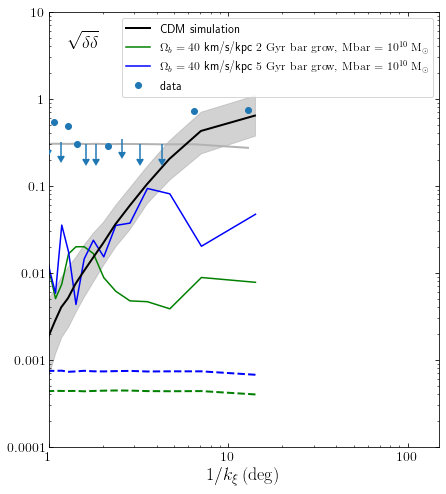

In [29]:
basefilename='/home/nil/Dropbox/streamgap-pepper/streamdata/pal5_multtime/fromJo/'
scaling ='spectrum'
save_figures=True
minxi= 0.25
poly_deg= 3
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,8)


plot_dens(os.path.join(basefilename,'pal5_t64sampling_X10_6-9_dens.dat'),
          poly_deg=poly_deg,
          color='k',zorder=2,ls='-',
          fill=True)



loglog(px,py,color='g',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{2 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px,pyerr,lw=2.,color='g',zorder=1,ls='--')

loglog(px1,py1,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc \rm{5 Gyr bar grow}, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='b',zorder=1,ls='--')


plot_dens_data(poly_deg=poly_deg,minxi=minxi,errsim_color='0.7')
legend(loc='upper right')
set_ranges_and_labels_dens()

if save_figures:
    plt.savefig('plots/power_Pal5_trailingarm_bargrow.pdf')

# $M_{\rm{bar}} = 5\times 10^{9} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc

In [ ]:
dir35='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/trailing/'
ra_t, dec_t,ra_l,dec_l=process_sample(dir35,out_format='radec')
xi_t,eta_t,xi_l,eta_l=process_sample(dir35,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t,dec_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l,dec_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $5\times 10^{9} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t,eta_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l,eta_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $5\times 10^{9} \rm{M}_{\odot}$')
plt.legend(loc='upper right')

plt.savefig('plots/5_109Msun_sky_coords.pdf',format='pdf',dpi=100)
plt.show()



# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc

In [ ]:
dir35_1='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/trailing/'
ra_t1, dec_t1,ra_l1,dec_l1=process_sample(dir35_1,out_format='radec')
xi_t1,eta_t1,xi_l1,eta_l1=process_sample(dir35_1,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t1,dec_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l1,dec_l1,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t1,eta_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l1,eta_l1,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('1010Msun_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 2 Gyr

In [ ]:
dir35_11='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_2Gyrbar/trailing/'
ra_t11, dec_t11,ra_l11,dec_l11=process_sample(dir35_11,out_format='radec')
xi_t11,eta_t11,xi_l11,eta_l11=process_sample(dir35_11,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t11,dec_t11,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l11,dec_l11,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'2Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t11,eta_t11,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l11,eta_l11,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'2Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('2Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 0.5 Gyr

In [ ]:
dir35_12='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_0p5Gyrbar/trailing/'
ra_t12, dec_t12,ra_l12,dec_l12=process_sample(dir35_12,out_format='radec')
xi_t12,eta_t12,xi_l12,eta_l12=process_sample(dir35_12,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t12,dec_t12,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l12,dec_l12,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'0.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t12,eta_t12,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l12,eta_l12,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'0.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('0p5Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 1 Gyr

In [ ]:
dir35_13='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1Gyrbar/trailing/'
ra_t13, dec_t13,ra_l13,dec_l13=process_sample(dir35_13,out_format='radec')
xi_t13,eta_t13,xi_l13,eta_l13=process_sample(dir35_13,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t13,dec_t13,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l13,dec_l13,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'1 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t13,eta_t13,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l13,eta_l13,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'1 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('1 Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 1.5 Gyr

In [ ]:
dir35_14='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1p5Gyrbar/trailing/'
ra_t14, dec_t14,ra_l14,dec_l14=process_sample(dir35_14,out_format='radec')
xi_t14,eta_t14,xi_l14,eta_l14=process_sample(dir35_14,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t14,dec_t14,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l14,dec_l14,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'1.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t14,eta_t14,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l14,eta_l14,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'1.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('1.5 Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 2.5 Gyr

In [ ]:
dir35_15='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_2p5Gyrbar/trailing/'
ra_t15, dec_t15,ra_l15,dec_l15=process_sample(dir35_15,out_format='radec')
xi_t15,eta_t15,xi_l15,eta_l15=process_sample(dir35_15,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t15,dec_t15,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l15,dec_l15,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'2.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t15,eta_t15,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l15,eta_l15,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'2.5 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('2.5 Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc 3 Gyr

In [ ]:
dir35_16='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_3Gyrbar/trailing/'
ra_t16, dec_t16,ra_l16,dec_l16=process_sample(dir35_16,out_format='radec')
xi_t16,eta_t16,xi_l16,eta_l16=process_sample(dir35_16,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t16,dec_t16,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l16,dec_l16,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'3 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t16,eta_t16,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l16,eta_l16,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'3 Gyr pat speed = 35 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('3 Gyr_1010Msun_patspeed35_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 2\times 10^{10} \rm{M}_{\odot}$, $\Omega = 35$ km/s/kpc

In [ ]:
dir35_2='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/2_1010Msun/trailing/'
ra_t2, dec_t2,ra_l2,dec_l2=process_sample(dir35_2,out_format='radec')
xi_t2,eta_t2,xi_l2,eta_l2=process_sample(dir35_2,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t2,dec_t2,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l2,dec_l2,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $2\times 10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t2,eta_t2,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l2,eta_l2,s=1,c='b',label='leading',alpha=0.01,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 35 km/s/kpc, Mbar = $2\times 10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('2_1010Msun_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 60$ km/s/kpc

In [ ]:
#these were run with the old code whose output format was only ra,dec

dir60='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed60/trailing/'

dir_lead = dir60.replace('trailing','leading')
allfname_trail_60= glob.glob(dir60 + '*.dat')
allfname_lead_60= glob.glob(dir_lead + '*.dat')

ra_t3=[]
dec_t3=[]

ra_l3=[]
dec_l3=[]
    

for i in range(len(allfname_trail_60)):
        ra_t3.append(numpy.loadtxt(allfname_trail_60[i])[:,0])
        dec_t3.append(numpy.loadtxt(allfname_trail_60[i])[:,1])
        
        
for ii in range(len(allfname_lead_60)):
        ra_l3.append(numpy.loadtxt(allfname_lead_60[ii])[:,0])
        dec_l3.append(numpy.loadtxt(allfname_lead_60[ii])[:,1])
        
        
ra_t3_all = np.array([item for sublist in ra_t3 for item in sublist])
dec_t3_all = np.array([item for sublist in dec_t3 for item in sublist])

ra_l3_all = np.array([item for sublist in ra_l3 for item in sublist])
dec_l3_all = np.array([item for sublist in dec_l3 for item in sublist])
    

mxieta_t3= pal5_util.radec_to_pal5xieta(ra_t3_all,dec_t3_all,degree=True)
xi_t3= mxieta_t3[:,0]
eta_t3=mxieta_t3[:,1]


mxieta_l3= pal5_util.radec_to_pal5xieta(ra_l3_all,dec_l3_all,degree=True)
xi_l3= mxieta_l3[:,0]
eta_l3=mxieta_l3[:,1]


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t3,dec_t3,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l3,dec_l3,s=1,c='b',alpha=0.1,label='leading',rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title('pat_speed = 60 km/s/kpc')

#plot xi, eta
plt.subplot(1,2,2)
plt.scatter(xi_t3,eta_t3,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l3,eta_l3,s=1,c='b',alpha=0.1,label='leading',rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title('pat_speed = 60 km/s/kpc')
plt.legend(loc='upper right')
plt.savefig('1010Msun_patspeed60_sky_coords.pdf',format='pdf')
plt.show()


# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 40$ km/s/kpc

In [ ]:
dir40='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40/trailing/'
ra_t4, dec_t4,ra_l4,dec_l4=process_sample(dir40,out_format='radec')
xi_t4,eta_t4,xi_l4,eta_l4=process_sample(dir40,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t4,dec_t4,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l4,dec_l4,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t4,eta_t4,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l4,eta_l4,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 40 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('plots/1010Msun_patspeed40_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 45$ km/s/kpc

In [ ]:
dir45='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed45/trailing/'
ra_t5, dec_t5,ra_l5,dec_l5=process_sample(dir45,out_format='radec')
xi_t5,eta_t5,xi_l5,eta_l5=process_sample(dir45,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t5,dec_t5,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l5,dec_l5,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 45 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t5,eta_t5,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l5,eta_l5,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 45 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('plots/1010Msun_patspeed45_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 50$ km/s/kpc

In [ ]:
dir50='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed50/trailing/'
ra_t6, dec_t6,ra_l6,dec_l6=process_sample(dir50,out_format='radec')
xi_t6,eta_t6,xi_l6,eta_l6=process_sample(dir50,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t6,dec_t6,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l6,dec_l6,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 50 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t6,eta_t6,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l6,eta_l6,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 50 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
plt.savefig('plots/1010Msun_patspeed50_sky_coords.pdf',format='pdf')
plt.show()

# $M_{\rm{bar}} = 10^{10} \rm{M}_{\odot}$, $\Omega = 55$ km/s/kpc

In [ ]:
dir55='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed55/trailing/'
ra_t7, dec_t7,ra_l7,dec_l7=process_sample(dir55,out_format='radec')
xi_t7,eta_t7,xi_l7,eta_l7=process_sample(dir55,out_format='xieta')


#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_t7,dec_t7,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_l7,dec_l7,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'pat speed = 55 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_t7,eta_t7,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_l7,eta_l7,s=1,c='b',label='leading',alpha=0.1,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'pat speed = 55 km/s/kpc, Mbar = $10^{10} \rm{M}_{\odot}$')
plt.legend(loc='upper right')
#plt.savefig('plots/1010Msun_patspeed55_sky_coords.pdf',format='pdf')
plt.show()

In [ ]:
#compute density along xi and save 

#midxi,nden,err = compute_ndenxi(xi_t,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar5_10_9_barspeed35_phi27_polydeg3.pdf')

midxi1,nden1,err1 = compute_ndenxi(xi_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi11,nden11,err11 = compute_ndenxi(xi_t11,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_2Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi12,nden12,err12 = compute_ndenxi(xi_t12,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_0p5Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi13,nden13,err13 = compute_ndenxi(xi_t13,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_1Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi14,nden14,err14 = compute_ndenxi(xi_t14,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_1p5Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi15,nden15,err15 = compute_ndenxi(xi_t15,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_2p5Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi16,nden16,err16 = compute_ndenxi(xi_t16,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_3Gyr_Mbar10_10barspeed35_phi27_polydeg3.pdf')

#midxi2,nden2,err2 = compute_ndenxi(xi_t2,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar2_10_10barspeed35_phi27_polydeg3.pdf')

#midxi3,nden3,err3 = compute_ndenxi(xi_t3,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed60_phi27_polydeg3.pdf')

midxi4,nden4,err4 = compute_ndenxi(xi_t4,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed40_phi27_polydeg3.pdf')

#midxi5,nden5,err5 = compute_ndenxi(xi_t5,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed45_phi27_polydeg3.pdf')

#midxi6,nden6,err6 = compute_ndenxi(xi_t6,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed50_phi27_polydeg3.pdf')

midxi7,nden7,err7 = compute_ndenxi(xi_t7,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_Mbar10_10barspeed55_phi27_polydeg3.pdf')

In [ ]:
#write the mean density
'''
outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar5_109_barphi27_patspeed35.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden)):
    fo.write(str(midxi[j]) + "   " + str(nden[j]) + "   " + str(err[j]) + "\n")
    
fo.close()

outdir1 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'
fo1=open(outdir1 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden1)):
    fo1.write(str(midxi1[j]) + "   " + str(nden1[j]) + "   " + str(err1[j]) + "\n")
    
fo1.close()

outdir11 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_2Gyrbar/'
fo11=open(outdir11 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_2Gyr_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo11.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden11)):
    fo11.write(str(midxi11[j]) + "   " + str(nden11[j]) + "   " + str(err11[j]) + "\n")
    
fo11.close()


outdir13 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1Gyrbar/'
fo13=open(outdir13 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_1Gyr_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo13.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden13)):
    fo13.write(str(midxi13[j]) + "   " + str(nden13[j]) + "   " + str(err13[j]) + "\n")
    
fo13.close()

outdir14 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1p5Gyrbar/'
fo14=open(outdir14 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_1p5Gyr_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo14.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden14)):
    fo14.write(str(midxi14[j]) + "   " + str(nden14[j]) + "   " + str(err14[j]) + "\n")
    
fo14.close()

'''

outdir15 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_2p5Gyrbar/'
fo15=open(outdir15 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_2p5Gyr_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo15.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden15)):
    fo15.write(str(midxi15[j]) + "   " + str(nden15[j]) + "   " + str(err15[j]) + "\n")
    
fo15.close()

outdir16 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_3Gyrbar/'
fo16=open(outdir16 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_3Gyr_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo16.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden16)):
    fo16.write(str(midxi16[j]) + "   " + str(nden16[j]) + "   " + str(err16[j]) + "\n")
    
fo16.close()



'''
outdir2 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/2_1010Msun/'
fo2=open(outdir2 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar2_1010_barphi27_patspeed35.dat','w')
fo2.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden2)):
    fo2.write(str(midxi2[j]) + "   " + str(nden2[j]) + "   " + str(err2[j]) + "\n")
    
fo2.close()

outdir3 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed60/'
fo3=open(outdir3 + 'Pal5_density_samples_polyfit3_trailing_SCFbarMbar10_10_barphi27_patspeed60.dat','w')
fo3.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden3)):
    fo3.write(str(midxi3[jj]) + "   " + str(nden3[jj]) + "   " + str(err3[jj]) + "\n")
    
fo3.close()


outdir4 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40/'
fo4=open(outdir4 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed40.dat','w')
fo4.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden4)):
    fo4.write(str(midxi4[j]) + "   " + str(nden4[j]) + "   " + str(err4[j]) + "\n")
    
fo4.close()

outdir5 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed45/'
fo5=open(outdir5 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed45.dat','w')
fo5.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden5)):
    fo5.write(str(midxi5[j]) + "   " + str(nden5[j]) + "   " + str(err5[j]) + "\n")
    
fo5.close()

outdir6 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed50/'
fo6=open(outdir6 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed50.dat','w')
fo6.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden6)):
    fo6.write(str(midxi6[j]) + "   " + str(nden6[j]) + "   " + str(err6[j]) + "\n")
    
fo6.close()

outdir7 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed55/'
fo7=open(outdir7 + 'Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed55.dat','w')
fo7.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden7)):
    fo7.write(str(midxi7[j]) + "   " + str(nden7[j]) + "   " + str(err7[j]) + "\n")
    
fo7.close()
'''

In [ ]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename=outdir + '2_1010Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar2_1010_barphi27_patspeed35.dat'
filename1=outdir + '1010Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed35.dat'
filename11=outdir + '1010Msun_patspeed35_2Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_2Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'
filename12=outdir + '1010Msun_patspeed35_0p5Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_0p5Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'
filename13=outdir + '1010Msun_patspeed35_1Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_1Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'
filename14=outdir + '1010Msun_patspeed35_1p5Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_1p5Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'
filename15=outdir + '1010Msun_patspeed35_2p5Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_2p5Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'
filename16=outdir + '1010Msun_patspeed35_3Gyrbar/Pal5_density_samples_bw0p1_polyfit3_trailing_3Gyr_SCFbarMbar1010_barphi27_patspeed35.dat'




filename2=outdir + '5_109Msun/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar5_109_barphi27_patspeed35.dat'
filename3=outdir + 'Mbar10_10_barphi27_patspeed60/Pal5_density_samples_polyfit3_trailing_SCFbarMbar10_10_barphi27_patspeed60.dat'
filename4=outdir + '1010Msun_patspeed40/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed40.dat'
filename5=outdir + '1010Msun_patspeed45/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed45.dat'
filename6=outdir + '1010Msun_patspeed50/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed50.dat'
filename7=outdir + '1010Msun_patspeed55/Pal5_density_samples_bw0p1_polyfit3_trailing_SCFbarMbar1010_barphi27_patspeed55.dat'




#px,py,pyerr=compute_Pk(filename, scaling = 'spectrum')
px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')
#px11,py11,pyerr11=compute_Pk(filename11, scaling = 'spectrum')
#px12,py12,pyerr12=compute_Pk(filename12, scaling = 'spectrum')
#px13,py13,pyerr13=compute_Pk(filename13, scaling = 'spectrum')
#px14,py14,pyerr14=compute_Pk(filename14, scaling = 'spectrum')
#px15,py15,pyerr15=compute_Pk(filename15, scaling = 'spectrum')
#px16,py16,pyerr16=compute_Pk(filename16, scaling = 'spectrum')
#px2,py2,pyerr2=compute_Pk(filename2, scaling = 'spectrum')
#px3,py3,pyerr3=compute_Pk(filename3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(filename4, scaling = 'spectrum')
#px5,py5,pyerr5=compute_Pk(filename5, scaling = 'spectrum')
#px6,py6,pyerr6=compute_Pk(filename6, scaling = 'spectrum')
px7,py7,pyerr7=compute_Pk(filename7, scaling = 'spectrum')

bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

#loglog(px,py,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $2\times 10^{10} \ \rm{M}_{\odot}$')
#loglog(px,pyerr,lw=2.,color='r',zorder=1,ls='--')

#loglog(px2,py2,color='g',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $5\times 10^{9} \ \rm{M}_{\odot}$')
#loglog(px2,pyerr2,lw=2.,color='g',zorder=1,ls='--')

loglog(px1,py1,color='k',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='k',zorder=1,ls='--')

#loglog(px12,py12,color='g',zorder=1,label=r'0.5 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px12,pyerr12,lw=2.,color='g',zorder=1,ls='--')

#loglog(px13,py13,color='r',zorder=1,label=r'1 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px13,pyerr13,lw=2.,color='r',zorder=1,ls='--')

#loglog(px14,py14,color='orange',zorder=1,label=r'1.5 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px14,pyerr14,lw=2.,color='orange',zorder=1,ls='--')

#loglog(px11,py11,color='b',zorder=1,label=r'2 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px11,pyerr11,lw=2.,color='b',zorder=1,ls='--')

#loglog(px15,py15,color='yellow',zorder=1,label=r'2.5 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px15,pyerr15,lw=2.,color='yellow',zorder=1,ls='--')

#loglog(px16,py16,color='magenta',zorder=1,label=r'3 Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px16,pyerr16,lw=2.,color='magenta',zorder=1,ls='--')


loglog(px4,py4,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px4,pyerr4,lw=2.,color='b',zorder=1,ls='--')

#loglog(px5,py5,color='orange',zorder=1,label=r'$\Omega_{b} = 45$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px5,pyerr5,lw=2.,color='orange',zorder=1,ls='--')

#loglog(px6,py6,color='pink',zorder=1,label=r'$\Omega_{b} = 50$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px6,pyerr6,lw=2.,color='pink',zorder=1,ls='--')

loglog(px7,py7,color='cyan',zorder=1,label=r'$\Omega_{b} = 55$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px7,pyerr7,lw=2.,color='cyan',zorder=1,ls='--')

#loglog(px3,py3,color='purple',zorder=1,label=r'$\Omega_{b} = 60$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px3,pyerr3,lw=2.,color='purple',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_only_trailing_varybar_age.pdf')



In [ ]:
#xi_both_arms=include_both_arms(xi_t,eta_t,xi_l,eta_l)
#xi_both_arms1=include_both_arms(xi_t1,eta_t1,xi_l1,eta_l1)
#xi_both_arms11=include_both_arms(xi_t11,eta_t11,xi_l11,eta_l11)
#xi_both_arms12=include_both_arms(xi_t12,eta_t12,xi_l12,eta_l12)
#xi_both_arms13=include_both_arms(xi_t13,eta_t13,xi_l13,eta_l13)
#xi_both_arms14=include_both_arms(xi_t14,eta_t14,xi_l14,eta_l14)
xi_both_arms15=include_both_arms(xi_t15,eta_t15,xi_l15,eta_l15)
xi_both_arms16=include_both_arms(xi_t16,eta_t16,xi_l16,eta_l16)
#xi_both_arms2=include_both_arms(xi_t2,eta_t2,xi_l2,eta_l2)
#xi_both_arms3=include_both_arms(xi_t3,eta_t3,xi_l3,eta_l3)
#xi_both_arms4=include_both_arms(xi_t4,eta_t4,xi_l4,eta_l4)
#xi_both_arms5=include_both_arms(xi_t5,eta_t5,xi_l5,eta_l5)
#xi_both_arms6=include_both_arms(xi_t6,eta_t6,xi_l6,eta_l6)
#xi_both_arms7=include_both_arms(xi_t7,eta_t7,xi_l7,eta_l7)

In [ ]:
#midxi_all,nden_all,err_all = compute_ndenxi(xi_both_arms,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar5_10_9_barspeed35_phi27_polydeg3.pdf')
#midxi_all1,nden_all1,err_all1 = compute_ndenxi(xi_both_arms1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed35_phi27_polydeg3.pdf')
#midxi_all12,nden_all12,err_all12 = compute_ndenxi(xi_both_arms12,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_0p5Gyr_Mbar10_10_barspeed35_phi27_polydeg3.pdf')
#midxi_all13,nden_all13,err_all13 = compute_ndenxi(xi_both_arms13,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_1Gyr_Mbar10_10_barspeed35_phi27_polydeg3.pdf')
#midxi_all14,nden_all14,err_all14 = compute_ndenxi(xi_both_arms14,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_1p5Gyr_Mbar10_10_barspeed35_phi27_polydeg3.pdf')

midxi_all15,nden_all15,err_all15 = compute_ndenxi(xi_both_arms15,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_2p5Gyr_Mbar10_10_barspeed35_phi27_polydeg3.pdf')
midxi_all16,nden_all16,err_all16 = compute_ndenxi(xi_both_arms16,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_3Gyr_Mbar10_10_barspeed35_phi27_polydeg3.pdf')

#midxi_all3,nden_all3,err_all3 = compute_ndenxi(xi_both_arms3,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed60_phi27_polydeg3.pdf')
#midxi_all4,nden_all4,err_all4 = compute_ndenxi(xi_both_arms4,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed40_phi27_polydeg3.pdf')
#midxi_all5,nden_all5,err_all5 = compute_ndenxi(xi_both_arms5,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed45_phi27_polydeg3.pdf')
#midxi_all6,nden_all6,err_all6 = compute_ndenxi(xi_both_arms6,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed50_phi27_polydeg3.pdf')
#midxi_all7,nden_all7,err_all7 = compute_ndenxi(xi_both_arms7,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_both_arms_Mbar10_10_barspeed55_phi27_polydeg3.pdf')

In [ ]:
'''
outdir12= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_0p5Gyrbar/'
fo_all12=open(outdir12 + 'Pal5_density_samples_polyfit3_both_arms_0p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all12.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all12)):
    fo_all12.write(str(midxi_all12[jj]) + "   " + str(nden_all12[jj]) + "   " + str(err_all12[jj]) + "\n")
    
fo_all12.close()

outdir13= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1Gyrbar/'
fo_all13=open(outdir13 + 'Pal5_density_samples_polyfit3_both_arms_1Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all13.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all13)):
    fo_all13.write(str(midxi_all13[jj]) + "   " + str(nden_all13[jj]) + "   " + str(err_all13[jj]) + "\n")
    
fo_all13.close()

outdir14= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_1p5Gyrbar/'
fo_all14=open(outdir14 + 'Pal5_density_samples_polyfit3_both_arms_1p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all14.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all14)):
    fo_all14.write(str(midxi_all14[jj]) + "   " + str(nden_all14[jj]) + "   " + str(err_all14[jj]) + "\n")
    
fo_all14.close()
'''
outdir15= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_2p5Gyrbar/'
fo_all15=open(outdir15 + 'Pal5_density_samples_polyfit3_both_arms_2p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all15.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all15)):
    fo_all15.write(str(midxi_all15[jj]) + "   " + str(nden_all15[jj]) + "   " + str(err_all15[jj]) + "\n")
    
fo_all15.close()

outdir16= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed35_3Gyrbar/'
fo_all16=open(outdir16 + 'Pal5_density_samples_polyfit3_both_arms_3Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all16.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all16)):
    fo_all16.write(str(midxi_all16[jj]) + "   " + str(nden_all16[jj]) + "   " + str(err_all16[jj]) + "\n")
    
fo_all16.close()

In [ ]:
#write the mean density

outdir= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
fo_all=open(outdir + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar5_109_barphi27_patspeed35.dat','w')
fo_all.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all)):
    fo_all.write(str(midxi_all[j]) + "   " + str(nden_all[j]) + "   " + str(err_all[j]) + "\n")
    
fo_all.close()

outdir1= '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'
fo_all1=open(outdir1 + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar10_10_barphi27_patspeed35.dat','w')
fo_all1.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all1)):
    fo_all1.write(str(midxi_all1[jj]) + "   " + str(nden_all1[jj]) + "   " + str(err_all1[jj]) + "\n")
    
fo_all1.close()



#write the mean density

outdir = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/5_109Msun/'
fo=open(outdir + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar5_109_barphi27_patspeed35.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all)):
    fo.write(str(midxi_all[j]) + "   " + str(nden_all[j]) + "   " + str(err_all[j]) + "\n")
    
fo.close()

outdir1 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun/'
fo1=open(outdir1 + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed35.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all1)):
    fo1.write(str(midxi_all1[j]) + "   " + str(nden_all1[j]) + "   " + str(err_all1[j]) + "\n")
    
fo1.close()

outdir3 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/Mbar10_10_barphi27_patspeed60/'
fo3=open(outdir3 + 'Pal5_density_samples_polyfit3_both_arms_SCFbarMbar10_10_barphi27_patspeed60.dat','w')
fo3.write("#xi    den_contrast    shot_noise" + '\n')
for jj in range(len(nden_all3)):
    fo3.write(str(midxi_all3[jj]) + "   " + str(nden_all3[jj]) + "   " + str(err_all3[jj]) + "\n")
    
fo3.close()


outdir4 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed40/'
fo4=open(outdir4 + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed40.dat','w')
fo4.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all4)):
    fo4.write(str(midxi_all4[j]) + "   " + str(nden_all4[j]) + "   " + str(err_all4[j]) + "\n")
    
fo4.close()

outdir5 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed45/'
fo5=open(outdir5 + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed45.dat','w')
fo5.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all5)):
    fo5.write(str(midxi_all5[j]) + "   " + str(nden_all5[j]) + "   " + str(err_all5[j]) + "\n")
    
fo5.close()

outdir6 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed50/'
fo6=open(outdir6 + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed50.dat','w')
fo6.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all6)):
    fo6.write(str(midxi_all6[j]) + "   " + str(nden_all6[j]) + "   " + str(err_all6[j]) + "\n")
    
fo6.close()

outdir7 = '/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/1010Msun_patspeed55/'
fo7=open(outdir7 + 'Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed55.dat','w')
fo7.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_all7)):
    fo7.write(str(midxi_all7[j]) + "   " + str(nden_all7[j]) + "   " + str(err_all7[j]) + "\n")
    
fo7.close()

In [ ]:
outdir='/home/nil/Dropbox/streamgap-pepper/sampled_SCFbar/'


filename1=outdir + '1010Msun/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed35.dat'
#filename11=outdir + '1010Msun_patspeed35_2Gyrbar/Pal5_density_samples_polyfit3_both_arms_2Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'
#filename12=outdir + '1010Msun_patspeed35_0p5Gyrbar/Pal5_density_samples_polyfit3_both_arms_0p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'
#filename13=outdir + '1010Msun_patspeed35_1Gyrbar/Pal5_density_samples_polyfit3_both_arms_1Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'
#filename14=outdir + '1010Msun_patspeed35_1p5Gyrbar/Pal5_density_samples_polyfit3_both_arms_1p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'
#filename15=outdir + '1010Msun_patspeed35_2p5Gyrbar/Pal5_density_samples_polyfit3_both_arms_2p5Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'
#filename16=outdir + '1010Msun_patspeed35_3Gyrbar/Pal5_density_samples_polyfit3_both_arms_3Gyr_SCFbarMbar10_10_barphi27_patspeed35.dat'


#filename2=outdir + '5_109Msun/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar5_109_barphi27_patspeed35.dat'
#filename3=outdir + 'Mbar10_10_barphi27_patspeed60/Pal5_density_samples_polyfit3_both_arms_SCFbarMbar10_10_barphi27_patspeed60.dat'
filename4=outdir + '1010Msun_patspeed40/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed40.dat'
#filename5=outdir + '1010Msun_patspeed45/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed45.dat'
#filename6=outdir + '1010Msun_patspeed50/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed50.dat'
filename7=outdir + '1010Msun_patspeed55/Pal5_density_samples_bw0p1_polyfit3_both_arms_SCFbarMbar1010_barphi27_patspeed55.dat'


px1,py1,pyerr1=compute_Pk(filename1, scaling = 'spectrum')
#px11,py11,pyerr11=compute_Pk(filename11, scaling = 'spectrum')
#px12,py12,pyerr12=compute_Pk(filename12, scaling = 'spectrum')
#px13,py13,pyerr13=compute_Pk(filename13, scaling = 'spectrum')
#px14,py14,pyerr14=compute_Pk(filename14, scaling = 'spectrum')
#px15,py15,pyerr15=compute_Pk(filename15, scaling = 'spectrum')
#px16,py16,pyerr16=compute_Pk(filename16, scaling = 'spectrum')

#px2,py2,pyerr2=compute_Pk(filename2, scaling = 'spectrum')
#px3,py3,pyerr3=compute_Pk(filename3, scaling = 'spectrum')
px4,py4,pyerr4=compute_Pk(filename4, scaling = 'spectrum')
#px5,py5,pyerr5=compute_Pk(filename5, scaling = 'spectrum')
#px6,py6,pyerr6=compute_Pk(filename6, scaling = 'spectrum')
px7,py7,pyerr7=compute_Pk(filename7, scaling = 'spectrum')

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

#loglog(px2,py2,color='g',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $5\times 10^{9} \ \rm{M}_{\odot}$')
#loglog(px2,pyerr2,lw=2.,color='g',zorder=1,ls='--')

loglog(px1,py1,color='r',zorder=1,label=r'$\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px1,pyerr1,lw=2.,color='r',zorder=1,ls='--')

loglog(px11,py11,color='k',zorder=1,label=r'2Gyr $\Omega_{b} = 35$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px11,pyerr11,lw=2.,color='k',zorder=1,ls='--')

loglog(px4,py4,color='b',zorder=1,label=r'$\Omega_{b} = 40$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px4,pyerr4,lw=2.,color='b',zorder=1,ls='--')

loglog(px5,py5,color='orange',zorder=1,label=r'$\Omega_{b} = 45$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px5,pyerr5,lw=2.,color='orange',zorder=1,ls='--')

loglog(px6,py6,color='pink',zorder=1,label=r'$\Omega_{b} = 50$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px6,pyerr6,lw=2.,color='pink',zorder=1,ls='--')

loglog(px7,py7,color='cyan',zorder=1,label=r'$\Omega_{b} = 55$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
loglog(px7,pyerr7,lw=2.,color='cyan',zorder=1,ls='--')

#loglog(px3,py3,color='purple',zorder=1,label=r'$\Omega_{b} = 60$\ km/s/kpc, Mbar = $10^{10} \ \rm{M}_{\odot}$')
#loglog(px3,pyerr3,lw=2.,color='purple',zorder=1,ls='--')

set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_both_arms_with2Gyrbar.pdf')

# Spiral arms : N=2, $\Omega = 24.5$ km/s/kpc, 1%

In [ ]:
dir_spiral='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N2_pat_speed24p5_1percent/trailing/'
ra_s_t, dec_s_t,ra_s_l,dec_s_l=process_sample(dir_spiral,out_format='radec')
xi_s_t,eta_s_t,xi_s_l,eta_s_l=process_sample(dir_spiral,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_s_t,dec_s_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_s_l,dec_s_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'spiral, N=2 pat speed = 24.5 km/s/kpc, $1 \%$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_s_t,eta_s_t,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_s_l,eta_s_l,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'spiral, N=2 pat speed = 24.5 km/s/kpc, $1 \%$')
plt.legend(loc='upper right')

#plt.savefig('plots/Pal5_spiral_N2_patspeed24p5_1percent_sky_coords.pdf',format='pdf',dpi=100)
plt.show()

# Spiral arms : N=4, $\Omega = 19.5$ km/s/kpc, 1%

In [ ]:
dir_spiral1='/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N4_pat_speed19p5_1percent/trailing/'
ra_s_t1, dec_s_t1,ra_s_l1,dec_s_l1=process_sample(dir_spiral1,out_format='radec')
xi_s_t1,eta_s_t1,xi_s_l1,eta_s_l1=process_sample(dir_spiral1,out_format='xieta')

#plot ra dec
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(ra_s_t1,dec_s_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(ra_s_l1,dec_s_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel('ra (deg)')
plt.ylabel('dec (deg)')
plt.title(r'spiral, N=4 pat speed = 19.5 km/s/kpc, $1 \%$')

#plot xi, eta

plt.subplot(1,2,2)
plt.scatter(xi_s_t1,eta_s_t1,s=1,c='r',label='trailing',rasterized=True)
plt.scatter(xi_s_l1,eta_s_l1,s=1,c='b',label='leading',alpha=1.,rasterized=True)
#plt.xlim(190,360)
#plt.ylim(-85,30)
plt.xlabel(r'$\xi$ (deg)')
plt.ylabel(r'$\eta$ (deg)')
plt.title(r'spiral, N=4 pat speed = 19.5 km/s/kpc, $1 \%$')
plt.legend(loc='upper right')

plt.savefig('plots/Pal5_spiral_N4_patspeed19p5_1percent_sky_coords.pdf',format='pdf',dpi=100)
plt.show()

In [ ]:
midxi_s,nden_s,err_s = compute_ndenxi(xi_s_t,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_spiral_N2_patspeed24p5_1percent_polydeg3.pdf')
midxi_s1,nden_s1,err_s1 = compute_ndenxi(xi_s_t1,minxi=0.25,maxxi=14.35,bw=0.1,fname='plots/nden_spiral_N4_patspeed19p5_1percent_polydeg3.pdf')
#write the mean density

outdirs = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N2_pat_speed24p5_1percent/'
fo=open(outdirs + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N2_pat_speed24p5_1percent.dat','w')
fo.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_s)):
    fo.write(str(midxi_s[j]) + "   " + str(nden_s[j]) + "   " + str(err_s[j]) + "\n")
    
fo.close()

outdirs1 = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N4_pat_speed19p5_1percent/'
fo1=open(outdirs1 + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N4_pat_speed19p5_1percent.dat','w')
fo1.write("#xi    den_contrast    shot_noise" + '\n')

for j in range(len(nden_s1)):
    fo1.write(str(midxi_s1[j]) + "   " + str(nden_s1[j]) + "   " + str(err_s1[j]) + "\n")
    
fo1.close()

In [ ]:
outdirs = '/home/nil/Dropbox/streamgap-pepper/sampled_spiral/N2_pat_speed24p5_1percent/'
filenames0=outdirs + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N2_pat_speed24p5_1percent.dat'
#filenames1=outdirs1 + 'Pal5_density_samples_bw0p1_polyfit3_spiral_N4_pat_speed19p5_1percent.dat'

px_s_0,py_s_0,pyerr_s_0=compute_Pk(filenames0, scaling = 'spectrum')
#px_s_1,py_s_1,pyerr_s_1=compute_Pk(filenames1, scaling = 'spectrum')

In [ ]:
bovy_plot.bovy_print(axes_labelsize=18.,xtick_labelsize=14.,ytick_labelsize=14.)
figsize(7,7)

loglog(px_s_0,py_s_0,color='k',zorder=1,label=r'spiral, N=2 $\Omega = 24.5$ km/s/kpc, $1 \%$')
loglog(px_s_0,pyerr_s_0,lw=2.,color='k',zorder=1,ls='--')

loglog(px_s_1,py_s_1,color='b',zorder=1,label=r'spiral, N=4 $\Omega = 19.5$ km/s/kpc, $1 \%$')
loglog(px_s_1,pyerr_s_1,lw=2.,color='b',zorder=1,ls='--')


set_ranges_and_labels_dens()
legend(loc='upper right')

bovy_plot.bovy_end_print('plots/power_trailing_arms_spiral.pdf')